# * Index
#### 0. 문제의 정의(problem definition) 및 관련 hr이론
#### 1. data 분포 살펴보기
#### 2. our best and most experienced employees에 대한 정의 - GE 9 block
#### 3. Left reason(3_cluster) - PCA분석 및 graph
#### 4. Predict which valuable employees will leave next - cosine similarity

<br />
<br />
<br />

# 0 . 문제의 정의(problem definition) 및 관련 hr이론 

<br />

###  - 문제의 정의
Kaggle에 있는 문제 소개 중

"Why are our best and most experienced employees leaving prematurely?" 

"Have fun with this database and try to predict which valuable employees will leave next." 
<br />

이 문제의 포인트를 요약해보면,

- 첫번째, our best and most experienced employees에 대한 **정의**가 선제되어야 한다.

- 두번째, predict가 핵심 키워드가 아니라 valuable employees will **leave next**이 핵심 키워드이다.

predict를 핵심 키워드로 생각해서 **classification**으로 접근하게 되면, accuracy가 높더라도 **현재 인원**에 대한 분류이다. 

또한 **새로운 data**가 들어왔을 때, 어떤 category에 속하는 가이다.

<br />
하지만 predict which valuable employees will leave next에서 precidt는 hr에서 단순히 **예측**이 아닌, 미리 알아서 이직을 **예방**을 하겠다는 의미이다.

따라서 이직한 인원들의 특징을 파악해서 이와 **현시점에서 이와 유사한 사람**들이 누가있는지 파악해야 한다.
<br />
<br />

### - 관련 hr이론
- **인적자원계획**은 현재 및 장래의 각 시점에서 기업이 필요로 하는 인원의수를 예측하고 이에 대한 사내의 인력공급을 계획해서 인력의 수급을 조정하는 계획활동이다.
- 

- HR planning (인력 계획에 대해서 서술해주기)
- 작년에 채용한 종업원은 몇명인지? 이번에 나간 인원은 몇명인지?
- 이직의 그래프
<br />


<가정사항>
- 승진 곧 직무의 상승 = 연봉의 상승을 의미하는 것으로 가정

In [39]:
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib.path import Path
from matplotlib.spines import Spine
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
import matplotlib.pylab as pylab

In [2]:
df_hr = pd.read_csv("HR_comma_sep.csv")

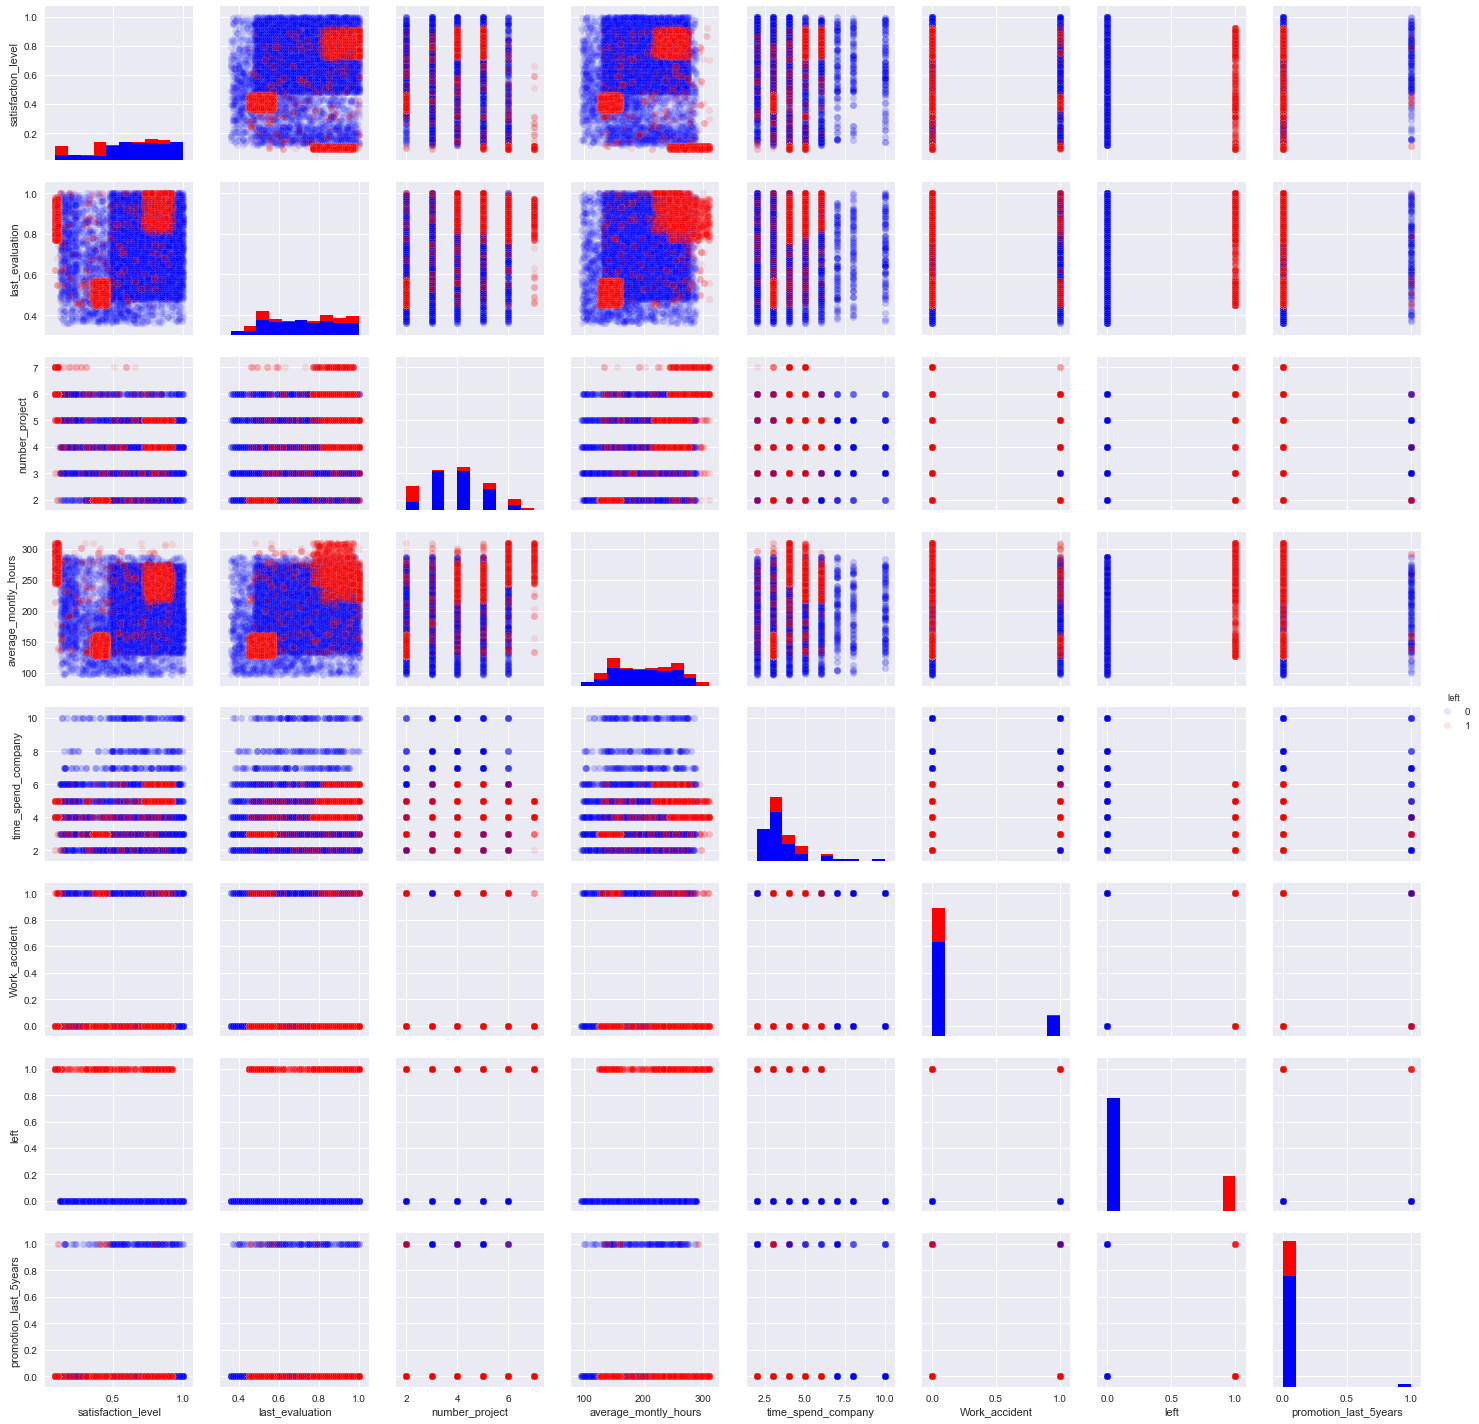

In [3]:
color = ["blue","red"]
sns.pairplot(df_hr,palette=color,hue = "left",plot_kws=dict(alpha=0.1))
plt.show()

# Ge-9block 그려보기

![image.png](attachment:image.png)

In [4]:
df_hr.quantile(q=[0.33,0.66])

satisfaction_level  last_evaluation  number_project  \
0.33                0.51             0.60             3.0   
0.66                0.76             0.82             4.0   

      average_montly_hours  time_spend_company  Work_accident  left  \
0.33                 168.0                 3.0            0.0   0.0   
0.66                 231.0                 4.0            0.0   0.0   

      promotion_last_5years  
0.33                    0.0  
0.66                    0.0

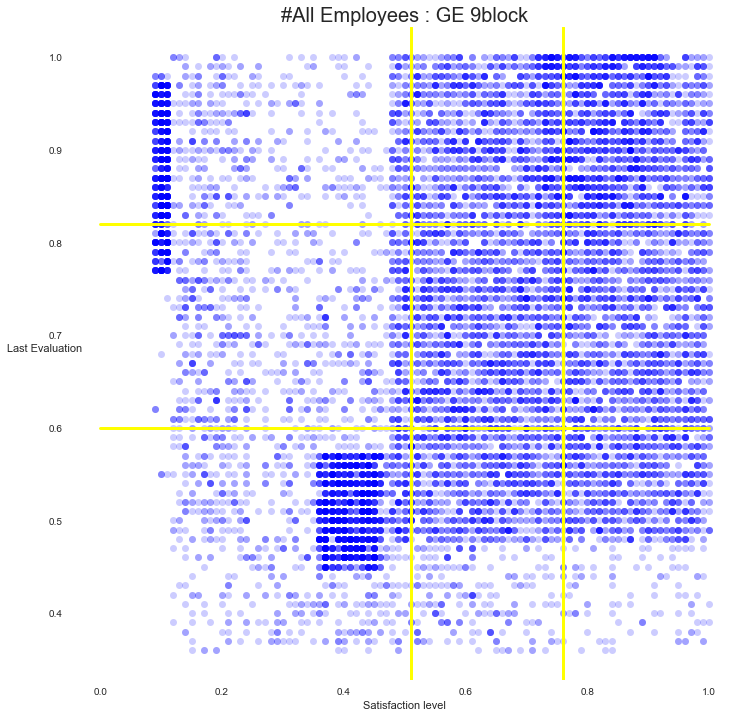

In [5]:
fig= plt.figure(num=1, figsize=(12,12))
ax = fig.add_subplot(111) 
ax.plot(df_hr.satisfaction_level,df_hr.last_evaluation,'o', alpha = 0.2,color = "b")
ax.set_facecolor('white')

plt.ylabel('Last Evaluation',rotation=0)
plt.plot([0.60,0.60],c="yellow",ls="-",lw=3)
plt.plot([0.82,0.82],c="yellow",ls="-",lw=3)
plt.axvline(x=0.51,c="yellow",ls="-",lw=3)
plt.axvline(x=0.76,c="yellow",ls="-",lw=3)
plt.title('#All Employees : GE 9block',fontsize=20)
plt.xlabel('Satisfaction level')
plt.show()


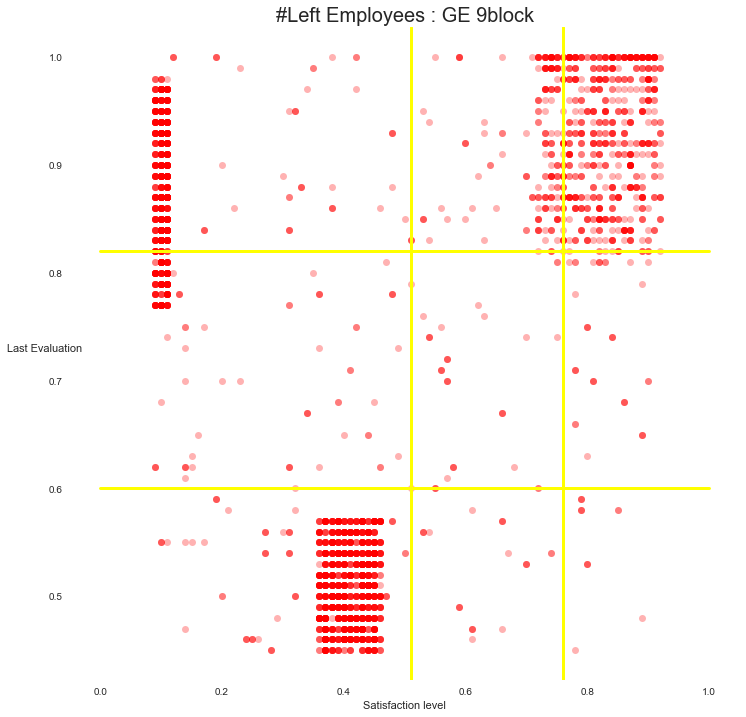

In [6]:
fig= plt.figure(num=1, figsize=(12,12))
ax = fig.add_subplot(111) 
ax.set_facecolor('white')
ax.plot(df_hr.satisfaction_level[df_hr.left==1],df_hr.last_evaluation[df_hr.left==1],'o', alpha = 0.3,color = "r")

plt.ylabel('Last Evaluation',rotation=0)
plt.plot([0.60,0.60],c="yellow",ls="-",lw=3)
plt.plot([0.82,0.82],c="yellow",ls="-",lw=3)
plt.axvline(x=0.51,c="yellow",ls="-",lw=3)
plt.axvline(x=0.76,c="yellow",ls="-",lw=3)
plt.title('#Left Employees : GE 9block',fontsize=20)
plt.xlabel('Satisfaction level')
plt.show()

### 이직자들의 cluster별 묶어주기

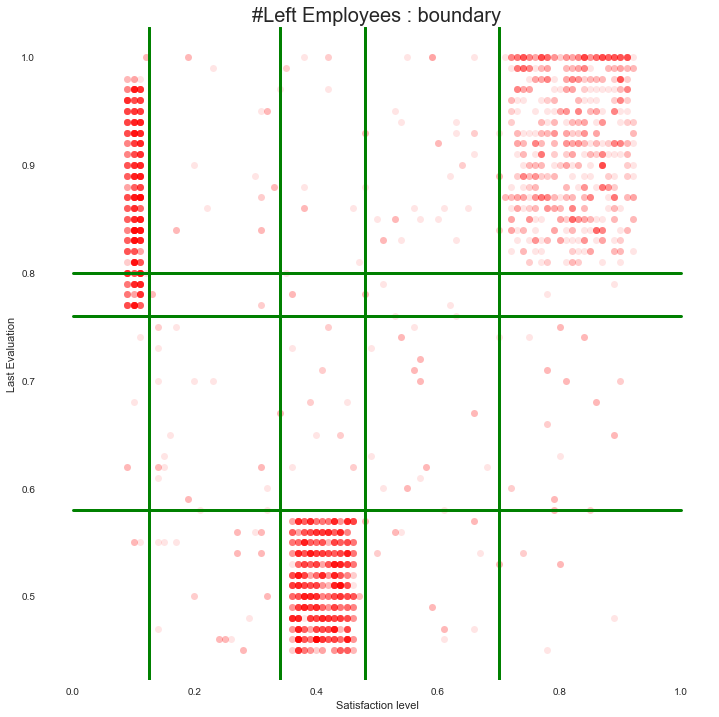

In [7]:
fig= plt.figure(num=1, figsize=(12,12))
ax = fig.add_subplot(111)
ax.set_facecolor('white')
ax.plot(df_hr.satisfaction_level[df_hr.left ==1],df_hr.last_evaluation[df_hr.left ==1],'o', alpha = 0.1,c="r")
plt.ylabel('Last Evaluation')
plt.plot([0.76,0.76],c="green",ls="-",lw=3)
plt.plot([0.58,0.58],c="green",ls="-",lw=3)
plt.plot([0.8,0.8],c="green",ls="-",lw=3)
plt.axvline(x=0.125,c="green",ls="-",lw=3)
plt.axvline(x=0.34,c="green",ls="-",lw=3)
plt.axvline(x=0.48,c="green",ls="-",lw=3)
plt.axvline(x=0.7,c="green",ls="-",lw=3)
plt.title('#Left Employees : boundary',fontsize=20)
plt.xlabel('Satisfaction level')
plt.show()

## cluster별 묶어주기 전에 표준화해주기

In [8]:
df_hr["salary"] = df_hr["salary"].replace({"high":3,"medium":2,"low":1})

In [9]:
scaler = MinMaxScaler()

In [10]:
df_hr[[u'number_project',u'average_montly_hours', u'time_spend_company', u'Work_accident', u'promotion_last_5years',u'salary']]= scaler.fit_transform(df_hr[[u'number_project', u'average_montly_hours', u'time_spend_company', u'Work_accident', u'promotion_last_5years',u'salary']])

#### cluster 1 : (0.7-1, 0.8-1)
#### cluster 2 : (0.34-0.48, 0-0.58)
#### cluster 3 : (0-0.125,0.76-1)

- clsuter 1

In [11]:
df_cluster_1 = df_hr[df_hr.satisfaction_level >0.7][df_hr.last_evaluation>0.8][df_hr.left == 1]
df_cluster_2 = df_hr[df_hr.satisfaction_level >0.34][df_hr.satisfaction_level <0.48][df_hr.last_evaluation<0.58][df_hr.left == 1]
df_cluster_3 = df_hr[df_hr.satisfaction_level <0.125][df_hr.last_evaluation>0.76][df_hr.left == 1]

C:\Users\hapro\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
C:\Users\hapro\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
C:\Users\hapro\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


In [117]:
df_cluster_1.columns

Index([u'satisfaction_level', u'last_evaluation', u'number_project',
       u'average_montly_hours', u'time_spend_company', u'Work_accident',
       u'left', u'promotion_last_5years', u'sales', u'salary'],
      dtype='object')

# 여기서는 pca 및 그래프로 문제 정의하기

# PCA 과정

In [119]:
def PCA_n(df):
    X_std = df.loc[:,[u'satisfaction_level', u'last_evaluation', u'number_project',u'average_montly_hours', u'time_spend_company', u'promotion_last_5years', u'salary',u'Work_accident']]
    mean_vec = np.mean(X_std, axis=0)
    cov_mat = (X_std - mean_vec).T.dot((X_std - mean_vec)) / (X_std.shape[0]-1)
    cov_mat = np.cov(X_std.T)
    eig_vals, eig_vecs = np.linalg.eig(cov_mat)
    u,s,v = np.linalg.svd(X_std.T)
    eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
    eig_pairs.sort(key=lambda x: x[0], reverse=True)
    tot = sum(eig_vals)
    var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    
    with plt.style.context('seaborn-whitegrid'):
         plt.figure(figsize=(6, 4))

         plt.bar(range(8), var_exp, alpha=0.5, align='center',label='individual explained variance')
         plt.step(range(8), cum_var_exp, where='mid',label='cumulative explained variance')
         plt.ylabel('Explained variance ratio')
         plt.xlabel('Principal components')
         plt.legend(loc='best')
         plt.tight_layout()
         plt.show()
    
    matrix_w = eig_pairs[0][1].reshape(-1,1)
    
    for i in range(5):
        matrix_w = np.hstack((matrix_w,eig_pairs[i+1][1].reshape(-1,1)))
        pass
    
    return pd.DataFrame(matrix_w,index=[u'satisfaction_level', u'last_evaluation', u'number_project',u'average_montly_hours', u'time_spend_company', u'promotion_last_5years',u'salay',u'Work_accident'])

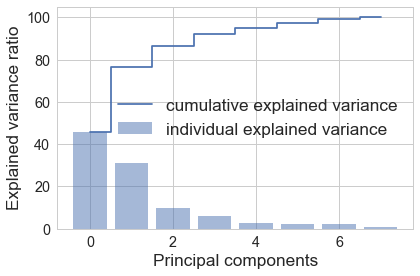

0         1         2         3         4  \
satisfaction_level    -0.000516  0.019540  0.015542  0.087172  0.304903   
last_evaluation       -0.002437 -0.024643 -0.013718 -0.032498  0.285282   
number_project        -0.008631  0.014975  0.955018 -0.270112 -0.105146   
average_montly_hours  -0.014009 -0.037529  0.244497  0.945155 -0.190684   
time_spend_company    -0.013037 -0.005526  0.165700  0.152182  0.882087   
promotion_last_5years  0.009381  0.019740 -0.007794  0.018299  0.008839   
salay                  0.953342 -0.301298  0.014649  0.000794  0.008231   
Work_accident          0.301004  0.951934 -0.000299  0.039635  0.002805   

                              5  
satisfaction_level    -0.459475  
last_evaluation       -0.790032  
number_project        -0.056531  
average_montly_hours  -0.063254  
time_spend_company     0.394344  
promotion_last_5years -0.044089  
salay                  0.004629  
Work_accident         -0.007956

In [120]:
PCA_n(df_cluster_1)

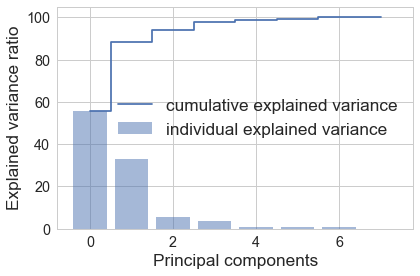

0         1         2         3         4  \
satisfaction_level    -0.004110 -0.004909  0.024804  0.005221  0.149742   
last_evaluation        0.006240  0.003763 -0.007605  0.009482  0.988418   
number_project         0.003597  0.003338  0.015605  0.367122  0.013349   
average_montly_hours   0.005838 -0.004923  0.086167  0.925003 -0.016322   
time_spend_company     0.000287  0.000522  0.001783  0.045087  0.009908   
promotion_last_5years  0.005036 -0.042781  0.994870 -0.086031  0.005105   
salay                 -0.999882 -0.010595  0.004971  0.006342  0.005564   
Work_accident          0.010416 -0.998991 -0.043179  0.000319  0.002840   

                              5  
satisfaction_level    -0.399038  
last_evaluation        0.078864  
number_project        -0.834732  
average_montly_hours   0.339518  
time_spend_company    -0.149876  
promotion_last_5years -0.005587  
salay                  0.001020  
Work_accident         -0.002054

In [121]:
PCA_n(df_cluster_2)

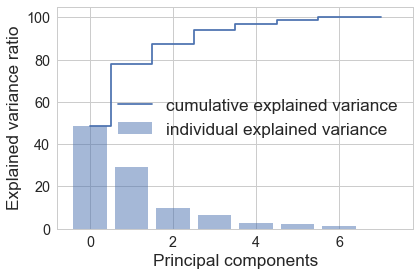

0         1         2         3         4  \
satisfaction_level    -0.001461  0.001286 -0.002098 -0.004849 -0.003170   
last_evaluation        0.010671  0.012462  0.042226  0.048090  0.851913   
number_project        -0.004243 -0.047712  0.896990  0.431646 -0.061660   
average_montly_hours  -0.017686 -0.012141  0.432817 -0.899268  0.043787   
time_spend_company     0.006373  0.001427  0.062463 -0.007966 -0.019894   
promotion_last_5years -0.010663 -0.005531 -0.004875 -0.047895 -0.517369   
salay                  0.995548  0.090301  0.014839 -0.014191 -0.015365   
Work_accident         -0.091007  0.994602  0.046323  0.010166 -0.014547   

                              5  
satisfaction_level     0.007209  
last_evaluation        0.518244  
number_project        -0.006768  
average_montly_hours  -0.020768  
time_spend_company    -0.041210  
promotion_last_5years  0.853919  
salay                  0.003233  
Work_accident         -0.002567

In [122]:
PCA_n(df_cluster_3)

보통의 경우 PCA 주성분에 이름을 붙인 뒤에 의미를 해석한다.
하지만 이 경우에는 연속형 자료가 아닌 카테고리 및 정수 값이 주성분에 크게 나온것을 알 수가 있다.


따라서 clsuter별 원성분이 주성분에 차지하는 비중으로 cluster간 비교를 하도록 하겠다.


첫 주성분에서는 cluster별로 3개구간 밖에 없는 salary의 차지하는 비중이 제일 컷으며,

cluster1과 cluster3의 두번째 주성분에서는 number_project, average_montly_hours,time_spend_company	순으로 차지하는 비중이 컸으나,

cluster 2에서는 승진의 여부가 가장 큰 차지를 하고 있었다.


또한 cluster1은 number_project, average_montly_hours,time_spend_company와 음의 상관관계를 가졌지만, cluster3와 양의 관계를 가지고 있었다.

좀 더 구체적으로 살펴보기 위해서 PCA biplot을 그려보았다.

# PCA biplot 그리기

In [123]:
def PCA_biplot(df,k_1,k_2):
    
    dat = df.loc[:,[u'satisfaction_level', u'last_evaluation', u'number_project',u'average_montly_hours', u'time_spend_company', u'promotion_last_5years',u'salary',u'Work_accident']]
    n = len(dat.columns)
    pca = PCA(n_components = n)
    pca.fit(dat)

    xvector = pca.components_[k_1] 
    yvector = pca.components_[k_2]
    xs = pca.transform(dat)[:,k_1] 
    ys = pca.transform(dat)[:,k_2]

    for i in range(len(xvector)):
        plt.arrow(0, 0, xvector[i]*max(xs)/2, yvector[i]*max(ys)/2,color='r', width=0.0009, head_width=0.0025)
        plt.text(xvector[i]*max(xs)/2-0.01, yvector[i]*max(ys)/2-0.01,list(dat.columns.values)[i], color='r',fontsize=7)

    for i in range(len(xs)):
        plt.plot(xs[i], ys[i], 'bo',alpha=0.2)
    
    plt.show()
    

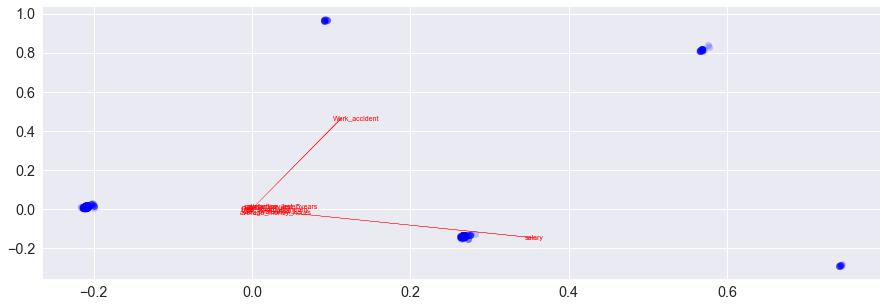

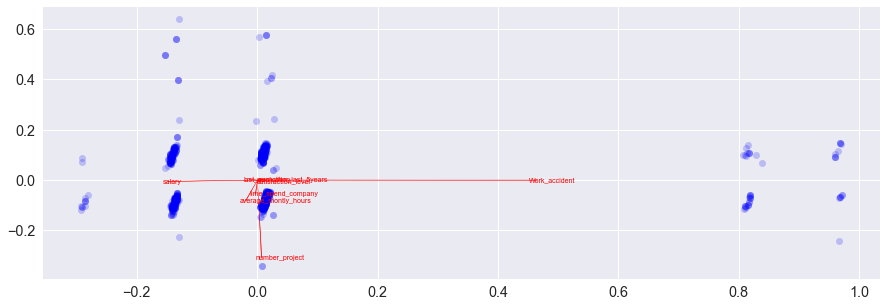

In [124]:
PCA_biplot(df_cluster_1,0,1)
PCA_biplot(df_cluster_1,1,2)

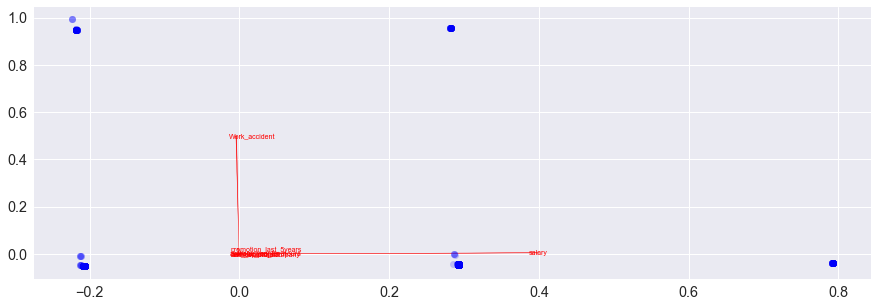

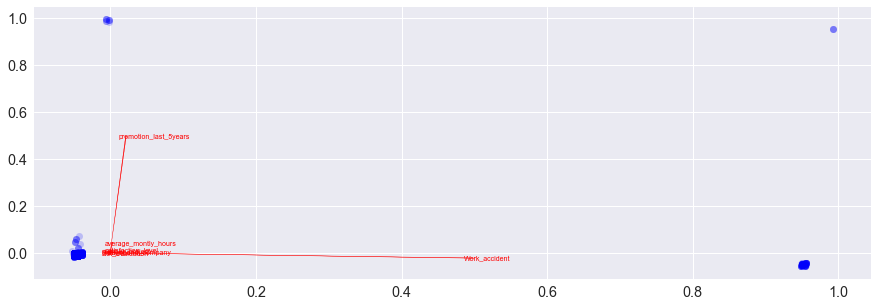

In [125]:
PCA_biplot(df_cluster_2,0,1)
PCA_biplot(df_cluster_2,1,2)

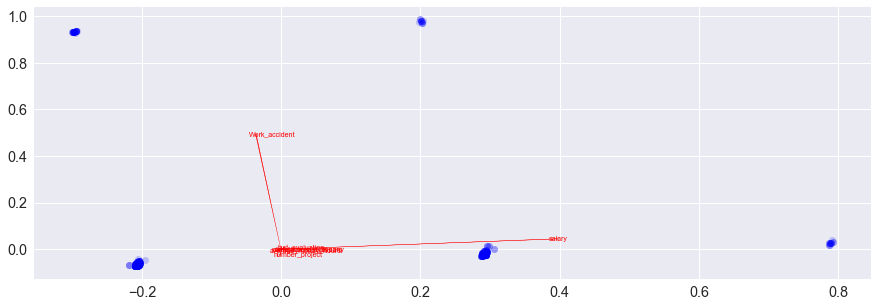

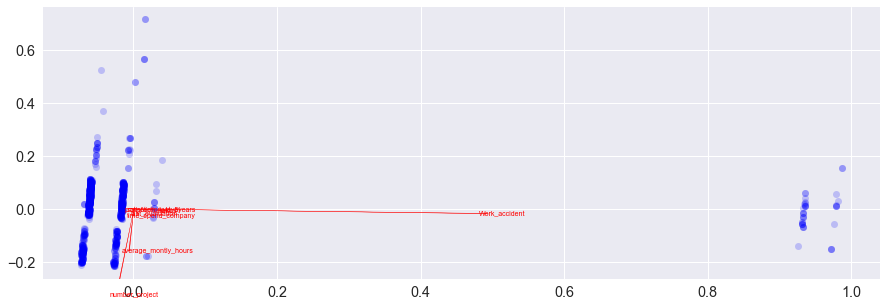

In [126]:
PCA_biplot(df_cluster_3,0,1)
PCA_biplot(df_cluster_3,1,2)

In [127]:
pl_1 = df_cluster_1["salary"].value_counts()/df_cluster_1["salary"].value_counts().sum()
pl_2 = df_cluster_2["salary"].value_counts()/df_cluster_2["salary"].value_counts().sum()
pl_3 = df_cluster_3["salary"].value_counts()/df_cluster_3["salary"].value_counts().sum()
A = pd.concat([pl_1,pl_2,pl_3],axis=1)
A.columns = ["cluster_1","cluster_2","cluster_3"]
A

cluster_1  cluster_2  cluster_3
0.0   0.605618   0.614024   0.594564
0.5   0.380899   0.355832   0.388448
1.0   0.013483   0.030144   0.016988

In [128]:
pl_1 = df_cluster_1["promotion_last_5years"].value_counts()/df_cluster_1["promotion_last_5years"].value_counts().sum()
pl_2 = df_cluster_2["promotion_last_5years"].value_counts()/df_cluster_2["promotion_last_5years"].value_counts().sum()
pl_3 = df_cluster_3["promotion_last_5years"].value_counts()/df_cluster_3["promotion_last_5years"].value_counts().sum()
A = pd.concat([pl_1,pl_2,pl_3],axis=1)
A.columns = ["cluster_1","cluster_2","cluster_3"]
A

cluster_1  cluster_2  cluster_3
0.0   0.998876   0.992136   0.996602
1.0   0.001124   0.007864   0.003398

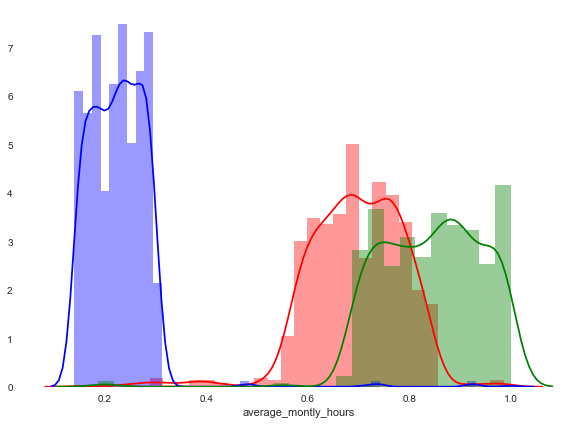

In [22]:
fig= plt.figure(num=1, figsize=(10,7))
ax = fig.add_subplot(111) 
ax.set_facecolor('white')

sns.distplot(df_cluster_1.average_montly_hours, color = 'r')
sns.distplot(df_cluster_2.average_montly_hours, color ='b')
sns.distplot(df_cluster_3.average_montly_hours, color ='g')
plt.show()

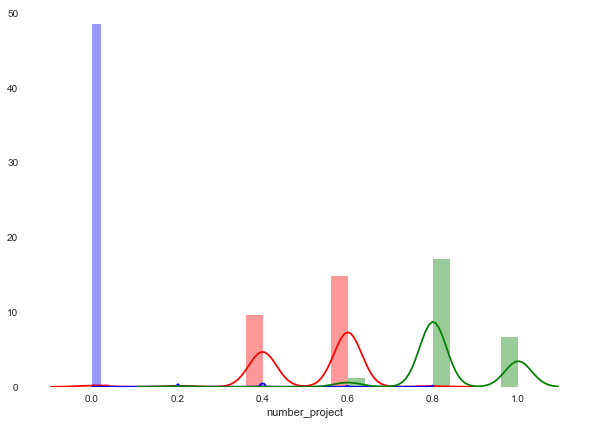

In [23]:
fig= plt.figure(num=1, figsize=(10,7))
ax = fig.add_subplot(111) 
ax.set_facecolor('white')

sns.distplot(df_cluster_1.number_project, color = 'r')
sns.distplot(df_cluster_2.number_project, color ='b')
sns.distplot(df_cluster_3.number_project, color ='g')
plt.show()

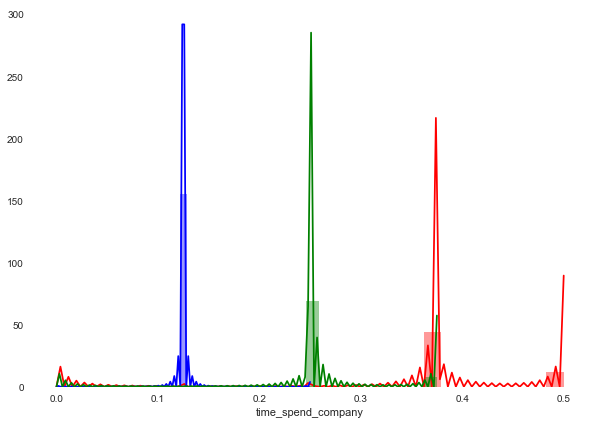

In [24]:
fig= plt.figure(num=1, figsize=(10,7))
ax = fig.add_subplot(111) 
ax.set_facecolor('white')

sns.distplot(df_cluster_1["time_spend_company"],color = 'r')
sns.distplot(df_cluster_2["time_spend_company"],color = 'b')
sns.distplot(df_cluster_3["time_spend_company"],color = 'g')
plt.show()

즉 number project와 time_spend_company와 같이 데이터가 퍼진 정도가 클 수록 pca 주성분에서의 값이 높게 나오는 것을 확인이 가능하다.
number project의 경우에

cluster 2 같은 경우에는 2시간(표준화 값 = 0)에 가장 많이 머무르고 있으며,
cluster 1 같은 경우에는 두 그룹보다 더 많이 퍼져있었다.

# radar chart

In [152]:
# 출처 : https://gist.github.com/sergiobuj/6721187


def _radar_factory(num_vars):
    theta = 2*np.pi * np.linspace(0, 1-1./num_vars, num_vars)
    theta += np.pi/2

    def unit_poly_verts(theta):
        x0, y0, r = [0.5] * 3
        verts = [(r*np.cos(t) + x0, r*np.sin(t) + y0) for t in theta]
        return verts

    class RadarAxes(PolarAxes):
        name = 'radar'
        RESOLUTION = 1

        def fill(self, *args, **kwargs):
            closed = kwargs.pop('closed', True)
            return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(theta * 180/np.pi, labels)

        def _gen_axes_patch(self):
            verts = unit_poly_verts(theta)
            return plt.Polygon(verts, closed=True, edgecolor='k')

        def _gen_axes_spines(self):
            spine_type = 'circle'
            verts = unit_poly_verts(theta)
            verts.append(verts[0])
            path = Path(verts)
            spine = Spine(self, spine_type, path)
            spine.set_transform(self.transAxes)
            return {'polar': spine}

    register_projection(RadarAxes)
    return theta

def radar_graph(labels = [], values = [],values_1 = [],values_2 = [],values_3 = [], optimum = []):
    
    params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
    pylab.rcParams.update(params)
    N = len(labels) 
    theta = _radar_factory(N)
    max_val = max(max(optimum), max(values))
    fig = plt.figure(num=1, figsize=(15,15))
    
    ax = fig.add_subplot(1, 1, 1, projection='radar')
    ax.set_facecolor('aliceblue')

    line1 = ax.plot(theta, values, color='r',ls="--",lw=2)
    line2 = ax.plot(theta, values_1, color='b',ls="--",lw=2)
    line3 = ax.plot(theta, values_2, color='g',ls="--",lw=2)
    line4 = ax.plot(theta, values_3, color='purple',ls="--",lw=2)
    
    ax.legend(['cluster_1',"cluster_2","cluster_3","remainder"],loc="right")
    ax.plot(theta, optimum, color='aliceblue',lw=1)
    ax.set_varlabels(labels)
   
    ax.set_title("# Cluster_per_score", weight='bold', position=(0.5, 1.13),
                     horizontalalignment='center', verticalalignment='center')
    
    plt.show()
    # plt.savefig("radar.png", dpi=100)

In [153]:
radar_1 =df_cluster_1[[u'satisfaction_level', u'last_evaluation', u'number_project',u'average_montly_hours', u'time_spend_company', u'promotion_last_5years',u'salary',u'Work_accident']].mean()
radar_2 =df_cluster_2[[u'satisfaction_level', u'last_evaluation', u'number_project',u'average_montly_hours', u'time_spend_company', u'promotion_last_5years',u'salary',u'Work_accident']].mean()
radar_3 =df_cluster_3[[u'satisfaction_level', u'last_evaluation', u'number_project',u'average_montly_hours', u'time_spend_company', u'promotion_last_5years',u'salary',u'Work_accident']].mean()
radar_4 = df_hr[[u'satisfaction_level', u'last_evaluation', u'number_project',u'average_montly_hours', u'time_spend_company', u'promotion_last_5years',u'salary',u'Work_accident']][df_hr.left==0].mean()

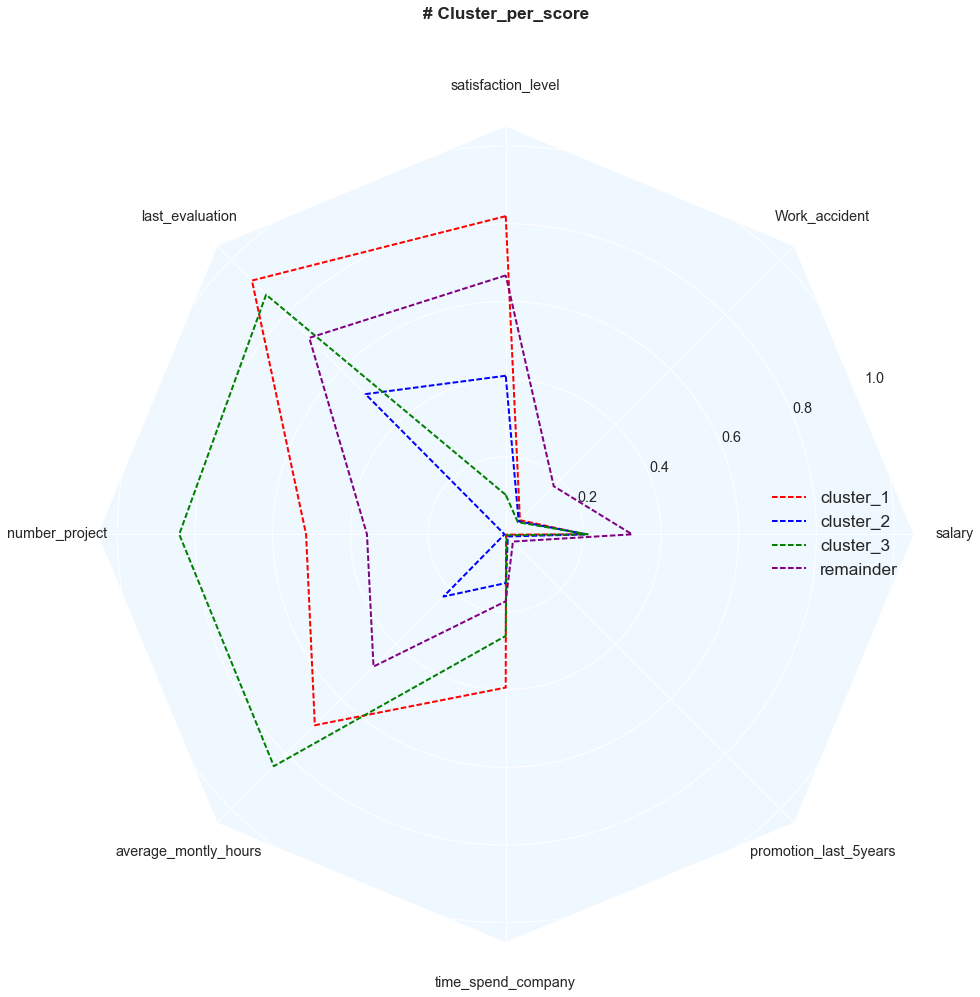

In [154]:
radar_graph(labels=radar_1.index,values=radar_1,values_1=radar_2,values_2=radar_3,values_3=radar_4,optimum=[1,1,1,1,1,1,1,1])

# 9block에 따라 labeling 해주기

In [62]:
df_hr["9-block"] = np.zeros(len(df_hr))

In [63]:
a = (df_hr.satisfaction_level >0) & (df_hr.satisfaction_level <=0.51) & (df_hr.last_evaluation>0) & (df_hr.last_evaluation<=0.6)
b = (df_hr.satisfaction_level >0) & (df_hr.satisfaction_level <=0.51) & (df_hr.last_evaluation>0.6) & (df_hr.last_evaluation<=0.82)
c = (df_hr.satisfaction_level >0) & (df_hr.satisfaction_level <=0.51) & (df_hr.last_evaluation>0.82) &(df_hr.last_evaluation<=1)
d = (df_hr.satisfaction_level >0.51)&(df_hr.satisfaction_level <=0.76)&(df_hr.last_evaluation>0)&(df_hr.last_evaluation<=0.6)
e = (df_hr.satisfaction_level >0.51)&(df_hr.satisfaction_level <=0.76)&(df_hr.last_evaluation>0.6)&(df_hr.last_evaluation<=0.82)
f = (df_hr.satisfaction_level >0.51)&(df_hr.satisfaction_level <=0.76)&(df_hr.last_evaluation>0.82)&(df_hr.last_evaluation<=1)
g = (df_hr.satisfaction_level >0.76)&(df_hr.satisfaction_level <=1)&(df_hr.last_evaluation>0)&(df_hr.last_evaluation<=0.6)
h = (df_hr.satisfaction_level >0.76)&(df_hr.satisfaction_level <=1)&(df_hr.last_evaluation>0.6)&(df_hr.last_evaluation<=0.82)
i = (df_hr.satisfaction_level >0.76)&(df_hr.satisfaction_level <=1)&(df_hr.last_evaluation>0.82)&(df_hr.last_evaluation<=1)

In [64]:
df_hr["9-block"][a] = 1
df_hr["9-block"][b] = 4
df_hr["9-block"][c] = 7
df_hr["9-block"][d] = 2
df_hr["9-block"][e] = 5
df_hr["9-block"][f] = 8
df_hr["9-block"][g] = 3
df_hr["9-block"][h] = 6
df_hr["9-block"][i] = 9

C:\Users\hapro\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\hapro\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\hapro\Anaconda2\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\hapro\Anaconda2\lib\site-packages\ipykernel\__m

In [65]:
df_hr["9-block"].value_counts()

1.0    2473
5.0    2035
9.0    1990
6.0    1800
8.0    1685
2.0    1346
7.0    1322
4.0    1204
3.0    1144
Name: 9-block, dtype: int64

# 유사도 구해주기
- 같은 그룹끼리 묶어 줘서 계산해주기

  - 카테고리 값으로 분류하기

In [67]:
df_689 = df_hr[(df_hr["9-block"] ==9)|(df_hr["9-block"] ==8)|(df_hr["9-block"] ==6)][df_hr["left"] ==0]
del df_689["left"]

C:\Users\hapro\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [68]:
df_cluster_1_mean = df_cluster_1.groupby(["sales","salary"]).mean()

In [71]:
alpha =pd.merge(df_689,df_cluster_1_mean,left_on=["sales","salary"],right_index=True,how="inner")

In [169]:
alpha.head()

satisfaction_level_x  last_evaluation_x  number_project_x  \
126                  0.89               0.81               0.4   
129                  0.89               0.66               0.4   
130                  0.80               0.67               0.2   
131                  0.95               0.87               0.2   
135                  0.56               0.85               0.2   

     average_montly_hours_x  time_spend_company_x  Work_accident_x  \
126                0.616822                 0.250              0.0   
129                0.649533                 0.125              0.0   
130                0.317757                 0.125              0.0   
131                0.523364                 0.000              0.0   
135                0.602804                 0.125              0.0   

     promotion_last_5years_x sales  salary  9-block  satisfaction_level_y  \
126                      0.0    IT     1.0      6.0                 0.735   
129                      0.0    IT     1.0      6.0                 0.735   
130                      0.0    IT     1.0      6.0                 0.735   
131                      0.0    IT     1.0      9.0                 0.735   
135                      0.0    IT     1.0      8.0                 0.735   

     last_evaluation_y  number_project_y  average_montly_hours_y  \
126              0.935               0.6                 0.78271   
129              0.935               0.6                 0.78271   
130              0.935               0.6                 0.78271   
131              0.935               0.6                 0.78271   
135              0.935               0.6                 0.78271   

     time_spend_company_y  Work_accident_y  left  promotion_last_5years_y  \
126                 0.375              0.0     1                      0.0   
129                 0.375              0.0     1                      0.0   
130                 0.375              0.0     1                      0.0   
131                 0.375              0.0     1                      0.0   
135                 0.375              0.0     1                      0.0   

     similarity  
126    0.828278  
129    0.814397  
130    0.777643  
131    0.773699  
135    0.814357

In [72]:
alpha_similarity = np.zeros(len(alpha))

for i in range(len(alpha)):
    distance = cosine_similarity(alpha.iloc[i,[0,1,2,3,4,5,6]],alpha.iloc[i,[10,11,12,13,14,15,16]])
    alpha_similarity[i] = distance.flatten()
    
alpha["similarity"] = alpha_similarity

C:\Users\hapro\Anaconda2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\hapro\Anaconda2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\Users\hapro\Anaconda2\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarn

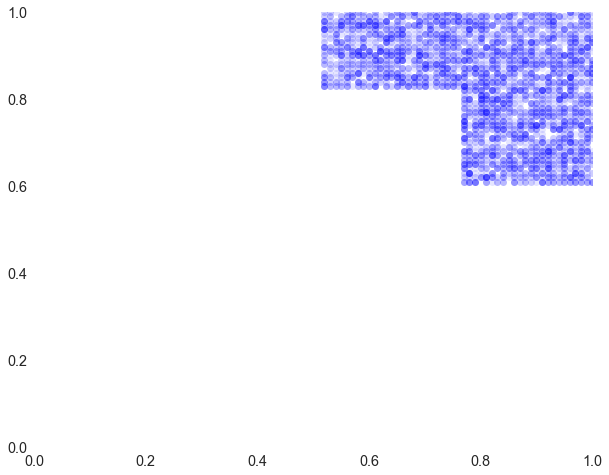

In [85]:
fig= plt.figure(num=1, figsize=(10,8))
ax = fig.add_subplot(111) 
ax.set_facecolor('white')

plt.plot(df_689.satisfaction_level,df_689.last_evaluation,'o', alpha = 0.1,c="blue")
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

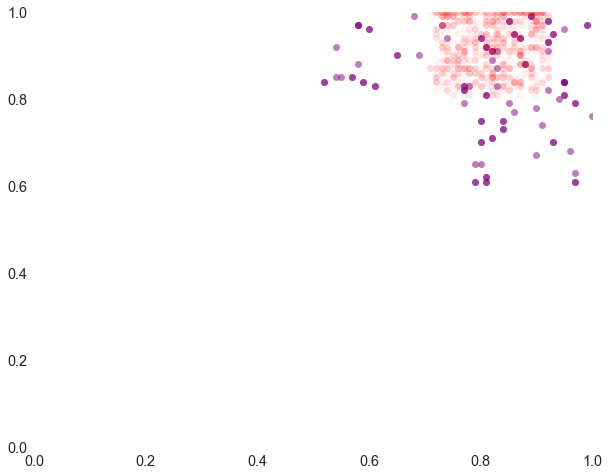

In [108]:
fig= plt.figure(num=1, figsize=(10,8))
ax = fig.add_subplot(111) 
ax.set_facecolor('white')

plt.plot(alpha.satisfaction_level_x[alpha.similarity >0.85],alpha.last_evaluation_x[alpha.similarity >0.85],'o', alpha = 0.5, c="purple")
plt.plot(df_cluster_1.satisfaction_level,df_cluster_1.last_evaluation,'o', alpha = 0.05,color = "r")
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

In [167]:
alpha_radar = alpha[alpha.similarity >0.9].mean()[:8]

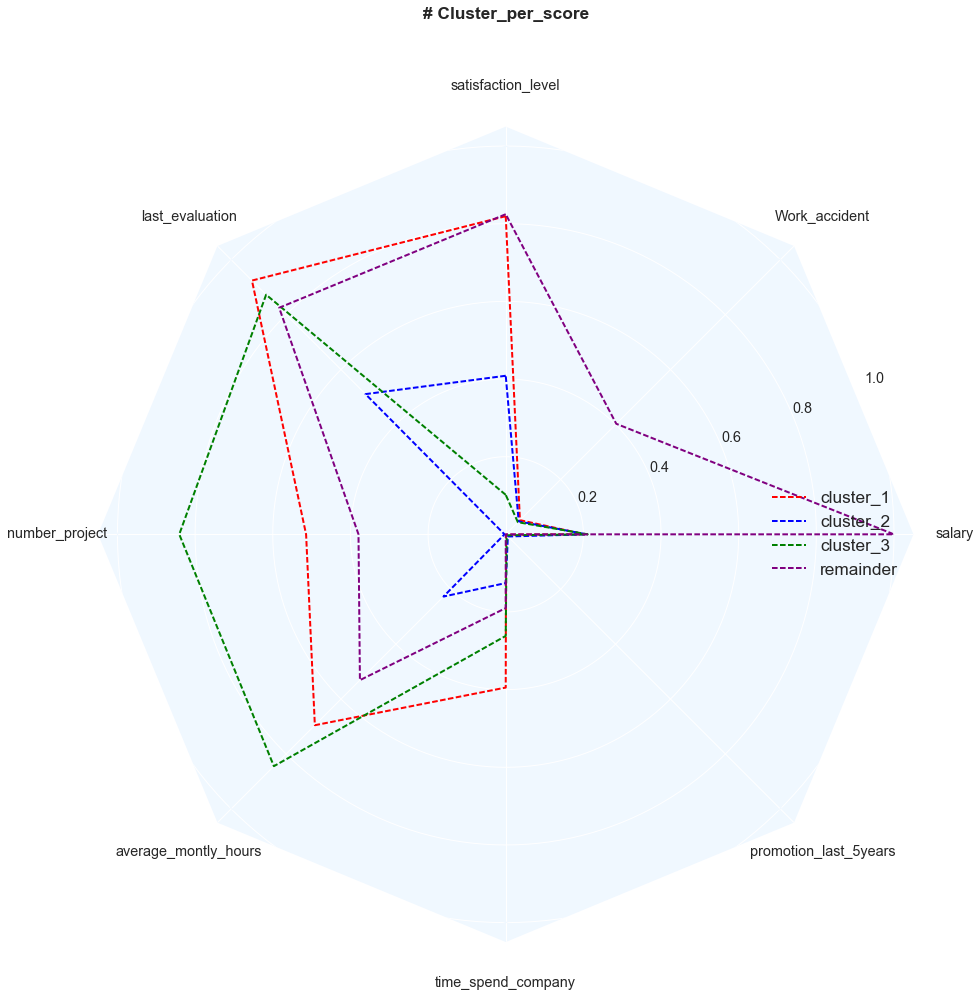

In [168]:
radar_graph(labels=radar_1.index,values=radar_1,values_1=radar_2,values_2=radar_3,values_3=alpha_radar,optimum=[1,1,1,1,1,1,1,1])